<a href="https://colab.research.google.com/github/RahulS247/Shapes_Classification/blob/main/Binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from PIL import Image
import numpy as np
import torch.optim as optim
import os
import torch.nn.functional as F

In [ ]:

os.chdir('/content/drive/MyDrive/dataset')


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [ ]:
!pwd
os.chdir('/content')
!pwd
!ls

/content
/content
drive  sample_data  train.csv  train.zip


In [4]:
import pandas as pd
#df = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')
df = pd.read_csv('/content/train.csv')
df

,Image_id,Label
0,0xf5c,No
1,0xf7f,No
2,0x7d0,Yes
3,0x161a,No
4,0x1407,No
...,...,...
4995,0x67a,Yes
4996,0xbd8,No
4997,0x7dd,Yes
4998,0xab0,No


In [64]:
import zipfile
with zipfile.ZipFile('/content/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
os.chdir('/content/train')
!pwd
!ls

/content/train
__MACOSX  train


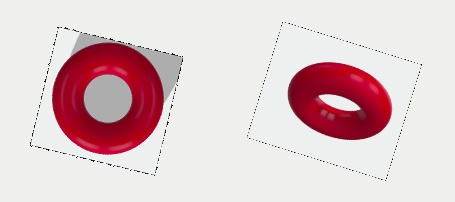

In [8]:
image = Image.open('/content/train/0x3ef.jpg')
image

In [9]:
image.size

(455, 202)

In [55]:
train_dir = '/content/train/'
target_dir = '/content/train.csv'
test_dir = '/content/test/'

In [52]:
batch_size = 32

In [12]:
len(os.listdir(train_dir))

5000

In [13]:
class ShapeDataset(Dataset):

  def __init__(self, train_dir, target_dir, transform = None):
    self.target_dir = target_dir
    self.train_dir = train_dir
    self.transform = transform

  def __getitem__(self, index):
    df=pd.read_csv(self.target_dir)
    label = df.iloc[index,1]
    image_path = os.path.join(self.train_dir,f"{str(df.iloc[index,0])}.jpg")
    image = Image.open(image_path).convert('RGB')

    if self.transform:
      image = self.transform(image)

      return image, label

  def __len__(self):
    return len(os.listdir(self.train_dir))


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



In [14]:
data = ShapeDataset(train_dir,target_dir,transform)


In [17]:
data[0][0].shape

torch.Size([3, 224, 224])

In [18]:
train_len = int(0.8*len(data))
valid_len = len(data)- train_len

In [19]:
train_len, valid_len

(4000, 1000)

In [20]:
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_len, valid_len])

In [21]:
len(train_dataset), len(val_dataset)

(4000, 1000)

In [53]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [23]:
# model creation
import torchvision.models as models

model = models.resnet18(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 47.0MB/s]


In [24]:
#model.fc.out_features = 1
model.fc = nn.Linear(model.fc.in_features,1)

for param in model.fc.parameters():
  param.requires_grad=True

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optim = optim.Adam(model.parameters(),lr=0.03)


In [ ]:
# train loop
#
epochs =3
#print(model)
train_losses = []
val_losses = []

for epoch in range(epochs):
  train_loss = 0.0
  val_loss =0.0
  running_loss= 0.0
  valrunning_loss = 0.0
  model.train()
  for image, labels in tqdm(train_loader):
    num_labels = [1 if label == "Yes" else 0 for label in labels]
    pred = model(image).to(device)
    num_labels= torch.tensor(num_labels).unsqueeze(1).to(device)

    loss = F.binary_cross_entropy_with_logits(pred, num_labels.float())

    optim.zero_grad()
    loss.backward()
    optim.step()

    running_loss += loss.item()/(len(image))
  train_loss = running_loss/(len(train_loader))
  #print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}")


  model.eval()
  with torch.no_grad():
    for image, labels in val_loader:
      num_labels = [1 if labels=="Yes" else 0 for label in labels]
      val_pred = model(image).to(device)
      num_labels= torch.tensor(num_labels).unsqueeze(1).to(device)

      val_loss = F.binary_cross_entropy_with_logits(val_pred, num_labels.float())

    valrunning_loss += val_loss.item()/(len(image))
    val_loss = valrunning_loss/(len(train_loader))
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print(f"Epoch [{epoch+1}/{epochs}], train_Loss: {train_loss:.4f}, valid_Loss: {val_loss:.4f}")


  6%|▋         | 8/125 [01:19<18:56,  9.72s/it]

In [ ]:
#to save model checkpoint
# checkpoint = {
#             "state_dict": model.state_dict(),
#             "optimizer":optimizer.state_dict(),
#         }

torch.save(model,model.pth)

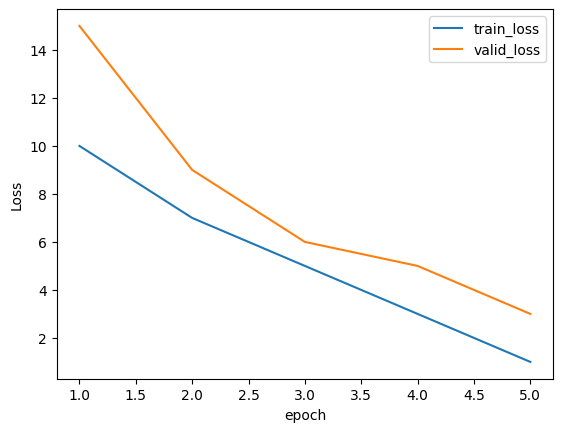

In [57]:
#plot
#train_losses = [10,7,5,3,1]
#val_losses = [15,9,6,5,3]
import matplotlib.pyplot as plt
plt.plot(range(1,epochs+1),train_losses,label='train_loss')
plt.plot(range(1,epochs+1),val_losses,label='valid_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
## Test case

In [ ]:
loaded_model = torch.load(model.pth)

In [79]:
class Testdataset(Dataset):
  def __init__(self,test_dir,transform=None):
    self.test_dir = test_dir
    self.transform = transform

  def __len__(self):
    return len(os.listdir(self.test_dir))

  def __getitem__(self,index):
    image_path = os.path.join(self.test_dir,os.listdir(test_dir)[index])
    image = Image.open(image_path).convert('RGB')

    if self.transform:
      image = self.transform(image)

    return image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [80]:
test_data = Testdataset(test_dir, transform)

In [81]:
len(test_data)

2000

In [86]:
test_loader = DataLoader(test_data,batch_size=1)

In [87]:
len(test_loader)

2000

In [72]:
for i in test_loader:
  print(i)

TypeError: Testdataset.__len__() takes 0 positional arguments but 1 was given

In [ ]:
loaded_model.eval()
with torch.no_grad():
  for i in test_loader():
